# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
import datetime


## 1. Business Understanding

### Problem statement

key mission is to understand how customers respond to offers by building a model by 1st applying data analysis to understand the data and grasp the needed preparations to make the data ready for modeling, then prepare the data by data wrangling and preprocessing, analysing and visualizing important aspects of the data for insights and then apply several models to know what works well and what doesn't.

### Metrics

for evaluation after i clean the data i will split it into Training Set (70%), and testing set (30%), then build and train the model using the training set, and use the testing set to assess the performance of our predictive model then use F1-score, which is the weighted average of Precision and Recall, F1 is usually more useful than accuracy, especially if we have an uneven class distribution, and this is our case.


## 2. Data Understanding

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1 Portfolio Data

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


we need to take out the channels values and separate so each channel is a seperate column, and create dummy variables for offer_type

In [6]:
portfolio.shape

(10, 6)

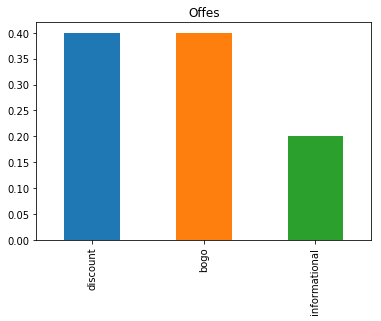

In [7]:
#Percentages of offer types
(portfolio.offer_type.value_counts()/portfolio.shape[0]).plot(kind="bar");
plt.title("Offes");

### 2.2 Profile Data

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile.shape

(17000, 5)

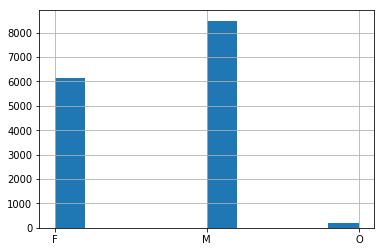

In [11]:
#distribution of gender
profile.gender.hist();

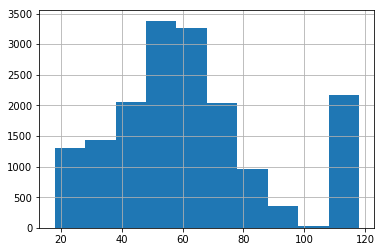

In [12]:
#distribution of age
profile.age.hist()

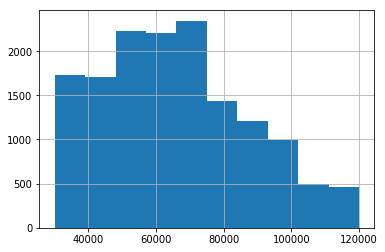

In [13]:
#distribution of income
profile.income.hist()

In [14]:
#calculating outliers
Q1= profile['age'].quantile(0.25)
Q3= profile['age'].quantile(0.75)
IQR= Q3-Q1
max_value=Q3+1.5*IQR
min_value=Q1-1.5*IQR

In [15]:
outliers= profile[(profile['age']>max_value) | (profile['age']<min_value)]

In [16]:
outliers

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [17]:
#null values
profile[(profile['gender'].isna())]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [18]:
#null values
profile[(profile['income'].isna())]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


### 2.3 Transcript Data

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.shape

(306534, 4)

In [22]:
transcript['event'].unique()


array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

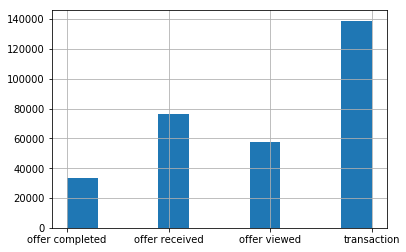

In [23]:
#distribution od events
transcript.event.hist()

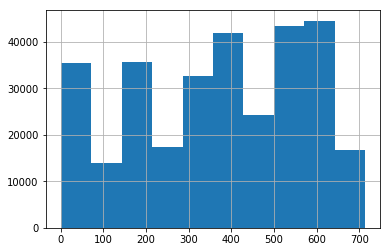

In [24]:
#distribution of time
transcript.time.hist()

## 3. Data Preparation

by taking a closer look at the data we will for the portfolio data to:
- create dummy variables for the channels column
- change duration to hours
- create dummy variables for the offer_type column
- rename id column to offer_id
- drop channels column

for the profile data we will :
- rename id to person_id
- drop outliers
- drop null values
- Change the datatype of 'became_member_on to readable date
- create a members year column out of became_member_on
- create a column counting the days since membership

for the transcript data we will:
- create dummy variables for the events column
- rename person column to person_id
- Extract each key that exists in the 'value' column to a seperate column
- drop the value column
- filter the data to have only those who viewed and completed offers

Merge the three dataframe into one for modeling

In [25]:
channels = portfolio['channels'].str.join(sep = '_').str.get_dummies(sep = '_')

In [26]:
channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [27]:
offer_dummies = pd.get_dummies(portfolio['offer_type'])


In [28]:
offer_dummies

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [29]:
portfolio = pd.concat([portfolio, offer_dummies, channels], axis = 1)


In [30]:
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

In [31]:
portfolio['duration'] =portfolio['duration']*24


In [32]:
portfolio = portfolio.drop(['channels'], axis = 1)

In [33]:
portfolio

,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,0,1,0,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,0,1,0,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,1,1,1,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,0,0,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,0,1,1,0,1


In [34]:
profile.rename(columns={"id":"user_id"}, inplace=True)

In [35]:
profile=profile.dropna()

In [36]:
profile[(profile['gender'].isna())]

,age,became_member_on,gender,user_id,income


In [37]:
profile[(profile['income'].isna())]

,age,became_member_on,gender,user_id,income


In [38]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')


In [39]:
profile['member_year'] =profile['became_member_on'].dt.year


In [40]:
profile['member_days'] = datetime.datetime.today().date() - profile['became_member_on'].dt.date
profile['member_days'] = profile['member_days'].dt.days



In [41]:
profile['gender']=profile.gender.astype("category").cat.codes

In [42]:
profile.head()

,age,became_member_on,gender,user_id,income,member_year,member_days
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1088
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1155
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,803
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,879
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,969


In [43]:
profile.drop('became_member_on',axis=1, inplace=True)


In [44]:
profile.head()

,age,gender,user_id,income,member_year,member_days
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1088
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1155
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,803
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,879
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,969


In [45]:
profile.head()

,age,gender,user_id,income,member_year,member_days
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1088
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1155
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,803
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,879
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,969


In [46]:
transcript.rename(columns={"person":"user_id"}, inplace=True)

In [47]:
transcript.head()

,event,user_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [48]:
transcript['received'] = transcript.event.apply(lambda x: 1 if x == 'offer received' else 0)
transcript['completed'] = transcript.event.apply(lambda x: 1 if x == 'offer completed' else 0)
transcript['viewed'] = transcript.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

In [49]:
transcript.head()

,event,user_id,time,value,received,completed,viewed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0


In [50]:
splited=transcript['value'].apply(pd.Series)
transcript_new=pd.concat([transcript, splited], axis=1)


In [51]:
def fix_id(id):
    if pd.isnull(id['offer id']):
        id_f = id['offer_id']
    else:
        id_f = id['offer id']
    return id_f

In [52]:
transcript_new['offer_id_new'] = transcript_new.apply(fix_id, axis=1)
transcript_new.head()

,event,user_id,time,value,received,completed,viewed,offer id,amount,offer_id,reward,offer_id_new
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [53]:
transcript_new.drop(['offer id','offer_id'],axis=1,inplace=True)
transcript_new.rename(columns={'offer_id_new':'offer_id'},inplace=True)
transcript_new.drop(['value'],axis=1,inplace=True)

In [54]:
f_transcript = transcript_new[(transcript_new['viewed'] == 1) | (transcript_new['completed'] == 1) ]


In [55]:
f_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 12650 to 306527
Data columns (total 9 columns):
event        91304 non-null object
user_id      91304 non-null object
time         91304 non-null int64
received     91304 non-null int64
completed    91304 non-null int64
viewed       91304 non-null int64
amount       0 non-null float64
reward       33579 non-null float64
offer_id     91304 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 7.0+ MB


In [56]:
f_transcript.drop('amount', axis=1, inplace=True)
f_transcript.fillna(0,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [57]:
f_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 12650 to 306527
Data columns (total 8 columns):
event        91304 non-null object
user_id      91304 non-null object
time         91304 non-null int64
received     91304 non-null int64
completed    91304 non-null int64
viewed       91304 non-null int64
reward       91304 non-null float64
offer_id     91304 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 6.3+ MB


In [58]:
f_transcript.head()

,event,user_id,time,received,completed,viewed,reward,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,0,0,1,0.0,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,0,0,1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,0,0,1,0.0,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837


In [59]:
f_transcript.drop('received', axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
f_transcript.head()

,event,user_id,time,completed,viewed,reward,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,0,1,0.0,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,0,1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,0,1,0.0,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837


In [61]:
f_transcript['event']=f_transcript.event.astype("category").cat.codes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
profile.head()

,age,gender,user_id,income,member_year,member_days
1,55,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1088
3,75,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1155
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,803
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,879
12,58,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,969


In [63]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
age            14825 non-null int64
gender         14825 non-null int8
user_id        14825 non-null object
income         14825 non-null float64
member_year    14825 non-null int64
member_days    14825 non-null int64
dtypes: float64(1), int64(3), int8(1), object(1)
memory usage: 709.4+ KB


In [64]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,bogo,discount,informational,email,mobile,social,web
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


In [65]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
difficulty       10 non-null int64
duration         10 non-null int64
offer_id         10 non-null object
offer_type       10 non-null object
reward           10 non-null int64
bogo             10 non-null uint8
discount         10 non-null uint8
informational    10 non-null uint8
email            10 non-null int64
mobile           10 non-null int64
social           10 non-null int64
web              10 non-null int64
dtypes: int64(7), object(2), uint8(3)
memory usage: 830.0+ bytes


In [66]:
merged_df =f_transcript.merge(portfolio,how='left',on='offer_id')


In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 18 columns):
event            91304 non-null int8
user_id          91304 non-null object
time             91304 non-null int64
completed        91304 non-null int64
viewed           91304 non-null int64
reward_x         91304 non-null float64
offer_id         91304 non-null object
difficulty       91304 non-null int64
duration         91304 non-null int64
offer_type       91304 non-null object
reward_y         91304 non-null int64
bogo             91304 non-null uint8
discount         91304 non-null uint8
informational    91304 non-null uint8
email            91304 non-null int64
mobile           91304 non-null int64
social           91304 non-null int64
web              91304 non-null int64
dtypes: float64(1), int64(10), int8(1), object(3), uint8(3)
memory usage: 10.8+ MB


In [68]:
merged_df.head()

,event,user_id,time,completed,viewed,reward_x,offer_id,difficulty,duration,offer_type,reward_y,bogo,discount,informational,email,mobile,social,web
0,1,389bc3fa690240e798340f5a15918d5c,0,0,1,0.0,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,5,1,0,0,1,1,1,1
1,1,d1ede868e29245ea91818a903fec04c6,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,0,0,0,1,1,1,1,0
2,1,102e9454054946fda62242d2e176fdce,0,0,1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,bogo,10,1,0,0,1,1,1,1
3,1,02c083884c7d45b39cc68e1314fec56c,0,0,1,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,10,1,0,0,1,1,1,0
4,1,be8a5d1981a2458d90b255ddc7e0d174,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,0,0,0,1,1,1,1,0


In [69]:
merged_df = merged_df.merge(profile,how ='left', on = 'user_id')


In [70]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 23 columns):
event            91304 non-null int8
user_id          91304 non-null object
time             91304 non-null int64
completed        91304 non-null int64
viewed           91304 non-null int64
reward_x         91304 non-null float64
offer_id         91304 non-null object
difficulty       91304 non-null int64
duration         91304 non-null int64
offer_type       91304 non-null object
reward_y         91304 non-null int64
bogo             91304 non-null uint8
discount         91304 non-null uint8
informational    91304 non-null uint8
email            91304 non-null int64
mobile           91304 non-null int64
social           91304 non-null int64
web              91304 non-null int64
age              82304 non-null float64
gender           82304 non-null float64
income           82304 non-null float64
member_year      82304 non-null float64
member_days      82304 non-null float64
dty

In [71]:
merged_df = merged_df.dropna(how='any',axis=0)


In [72]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 91303
Data columns (total 23 columns):
event            82304 non-null int8
user_id          82304 non-null object
time             82304 non-null int64
completed        82304 non-null int64
viewed           82304 non-null int64
reward_x         82304 non-null float64
offer_id         82304 non-null object
difficulty       82304 non-null int64
duration         82304 non-null int64
offer_type       82304 non-null object
reward_y         82304 non-null int64
bogo             82304 non-null uint8
discount         82304 non-null uint8
informational    82304 non-null uint8
email            82304 non-null int64
mobile           82304 non-null int64
social           82304 non-null int64
web              82304 non-null int64
age              82304 non-null float64
gender           82304 non-null float64
income           82304 non-null float64
member_year      82304 non-null float64
member_days      82304 non-null float64
dty

In [73]:
merged_df.head()

,event,user_id,time,completed,viewed,reward_x,offer_id,difficulty,duration,offer_type,...,informational,email,mobile,social,web,age,gender,income,member_year,member_days
0,1,389bc3fa690240e798340f5a15918d5c,0,0,1,0.0,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,...,0,1,1,1,1,65.0,1.0,53000.0,2018.0,879.0
1,1,d1ede868e29245ea91818a903fec04c6,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,...,1,1,1,1,0,53.0,2.0,52000.0,2017.0,1025.0
2,1,102e9454054946fda62242d2e176fdce,0,0,1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,bogo,...,0,1,1,1,1,69.0,0.0,57000.0,2016.0,1423.0
3,1,02c083884c7d45b39cc68e1314fec56c,0,0,1,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,...,0,1,1,1,0,20.0,0.0,30000.0,2016.0,1457.0
4,1,be8a5d1981a2458d90b255ddc7e0d174,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,...,1,1,1,1,0,39.0,1.0,51000.0,2014.0,2233.0


## 4. Data Analysis and visualization

In [74]:
import seaborn as sb

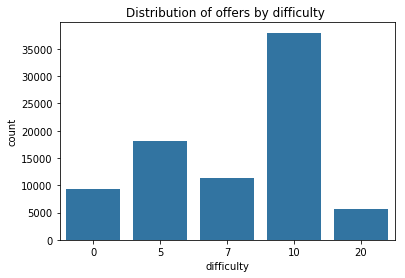

In [75]:
#Distribution of offers by difficulty
base_color=sb.color_palette()[0]
sb.countplot(data = merged_df ,x= 'difficulty', color = base_color)
plt.title('Distribution of offers by difficulty ');

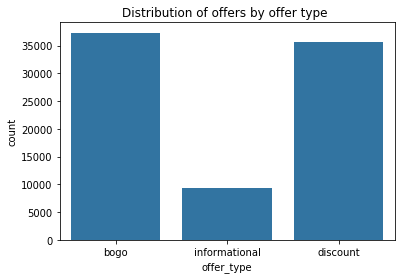

In [76]:
#Distribution of offers by offer type
base_color=sb.color_palette()[0]
sb.countplot(data = merged_df ,x= 'offer_type', color = base_color)
plt.title('Distribution of offers by offer type ');

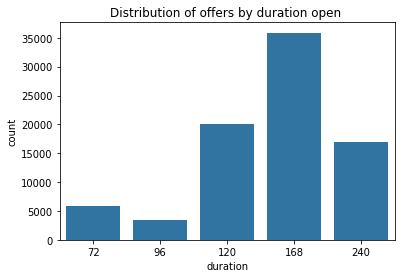

In [77]:
#'Distribution of offers by duration open 
base_color=sb.color_palette()[0]
sb.countplot(data = merged_df ,x= 'duration', color = base_color)
plt.title('Distribution of offers by duration open ');

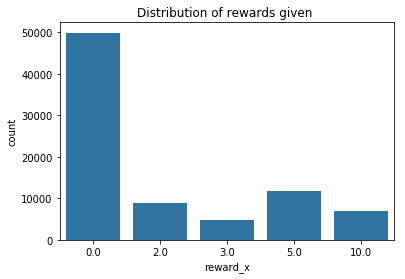

In [78]:
#Distribution of rewards given
base_color=sb.color_palette()[0]
sb.countplot(data = merged_df ,x= 'reward_x', color = base_color)
plt.title('Distribution of rewards given ');

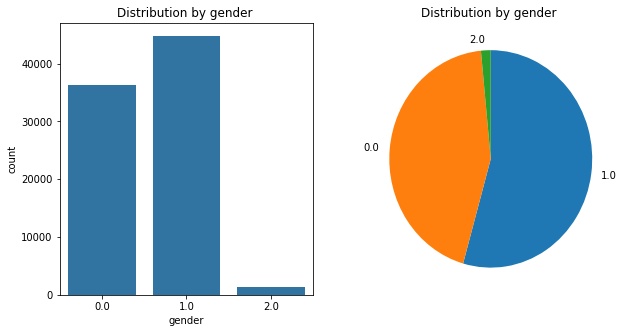

In [79]:
#Distribution by gender
plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sb.countplot(data = merged_df ,x= 'gender', color = base_color)
plt.title('Distribution by gender ')
plt.subplot(1,2,2)
sorted_counts= data = merged_df['gender'].value_counts()
plt.pie(sorted_counts,labels=sorted_counts.index, startangle=90, counterclock=False)
plt.title('Distribution by gender ');

In [80]:
#There are more male customers than there are female customers

Text(0.5,0,'age')

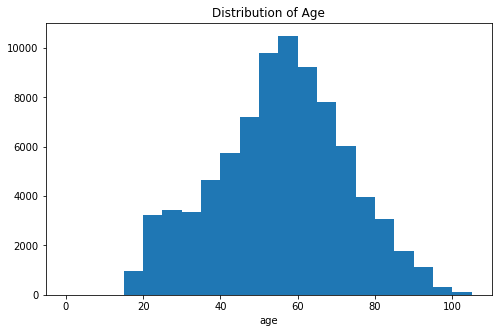

In [81]:
#Distribution of Age
binsize = 5
bins = np.arange(0, merged_df['age'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = merged_df, x = 'age', bins = bins)
plt.title('Distribution of Age')
plt.xlabel('age')


The most common age customers are 50-70


Text(0.5,0,'income')

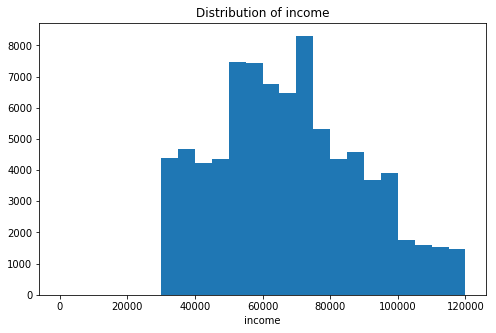

In [82]:
#Distribution of income
binsize = 5000
bins = np.arange(0, merged_df['income'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = merged_df, x = 'income', bins = bins)
plt.title('Distribution of income')
plt.xlabel('income')

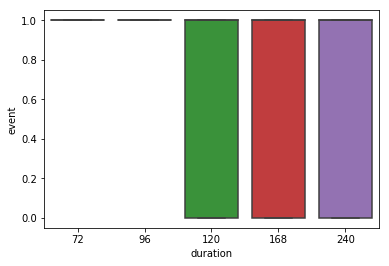

In [83]:
sns.boxplot(data = merged_df, x='duration', y='event')


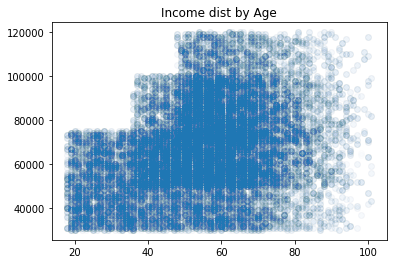

In [84]:
#Income dist by Age
plt.scatter(merged_df.age, merged_df.income, alpha=0.01)
plt.title("Income dist by Age");

average salaries for all age groups are 50k to 100k

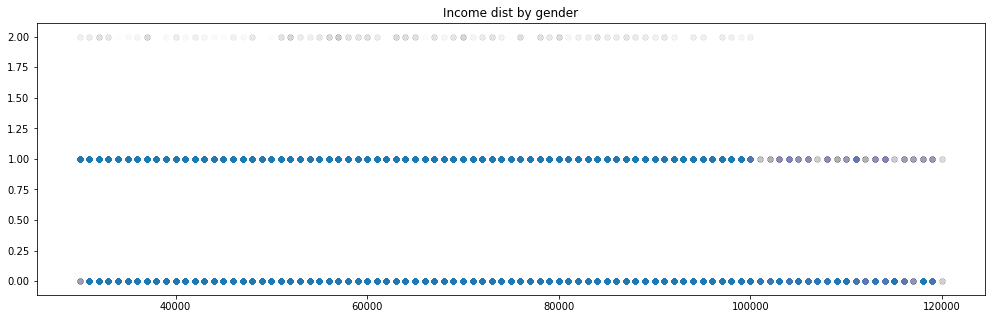

In [85]:
#Income dist by gender
plt.figure(figsize=[17, 5])
plt.scatter(merged_df.income, merged_df.gender, alpha=0.003)
plt.title("Income dist by gender");

Customers with salaries more than 100k are mostly females

In [86]:
completed_o=merged_df[merged_df['completed']==1]
completed_o['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5003
2298d6c36e964ae4a3e7e9706d1fb8c2    4886
9b98b8c7a33c4b65b9aebfe6a799e6d9    4188
f19421c1d4aa40978ebb69ca19b0e20d    4103
2906b810c7d4411798c6938adc9daaa5    3911
ae264e3637204a6fb9bb56bc8210ddfd    3657
0b1e1539f2cc45b7b9fa7c272da2e1d7    3386
4d5c57ea9a6940dd891ad53e9dbe8da0    3310
Name: offer_id, dtype: int64

Text(0.5,1,'completed offers')

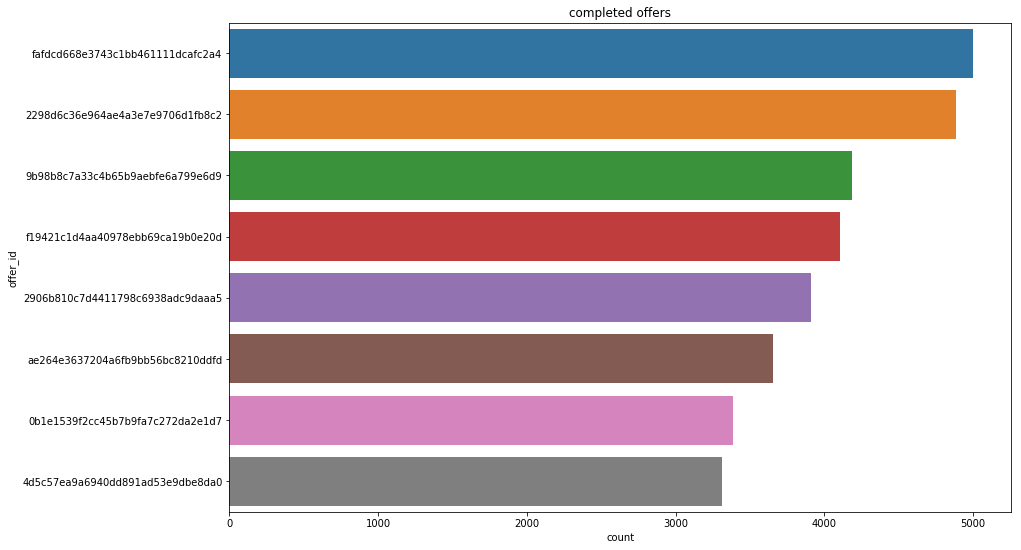

In [87]:
#completed offers
gr = plt.subplots(figsize=(14,9))
gr =sns.countplot(data=completed_o, order = completed_o['offer_id'].value_counts().index, y = 'offer_id')
gr.set_title('completed offers')

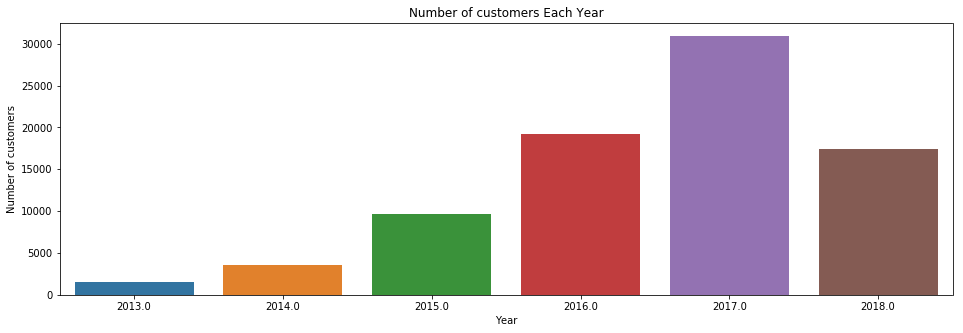

In [88]:
#number of starbucks customers increased every year
plt.figure(figsize=(16, 5))
sns.countplot(merged_df['member_year'])
plt.title('Number of customers Each Year')
plt.ylabel('Number of customers')
plt.xlabel('Year')
plt.xticks()
plt.show();

the year that added customers the most is the year 2017

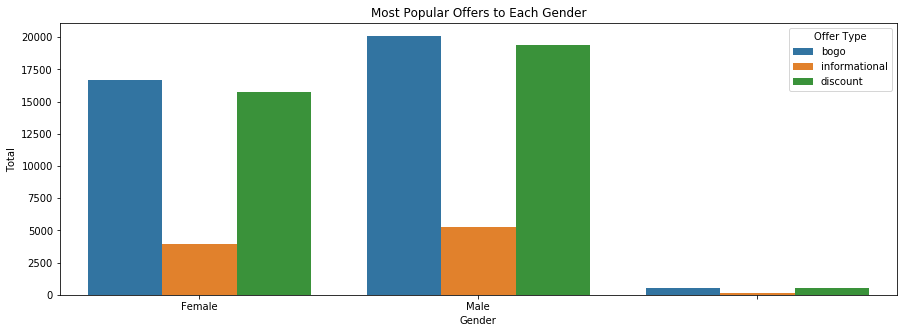

In [89]:
#offers preferances by gender
plt.figure(figsize=(15, 5))
g = sns.countplot(x='gender', hue="offer_type", data= merged_df)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The most common offer type among both genders is the BOGO offer then the discount offer ,and the least is the informational offer

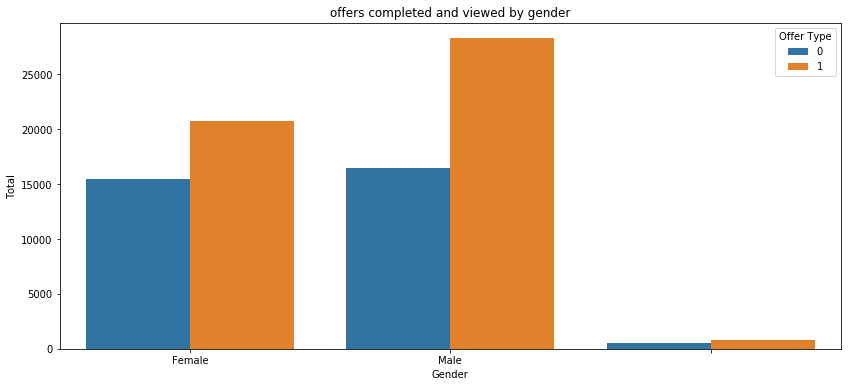

In [90]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= merged_df)
plt.title('offers completed and viewed by gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [91]:
#men are more likely to view and complete offers.

In [92]:
merged_df.describe()

,event,time,completed,viewed,reward_x,difficulty,duration,reward_y,bogo,discount,informational,email,mobile,social,web,age,gender,income,member_year,member_days
count,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.0,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000,82304.000000
mean,0.605803,372.313253,0.394197,0.605803,1.950586,8.033085,161.286159,4.639288,0.453161,0.433114,0.113725,1.0,0.931947,0.706624,0.812512,55.110578,0.574881,67256.451691,2016.539476,1263.243913
std,0.488681,197.969964,0.488681,0.488681,3.028978,4.586826,49.648791,3.338482,0.497804,0.495509,0.317479,0.0,0.251838,0.455312,0.390305,17.021547,0.524742,21357.315304,1.175600,411.728999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18.000000,0.000000,30000.000000,2013.000000,712.000000
25%,0.000000,198.000000,0.000000,0.000000,0.000000,5.000000,120.000000,2.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,44.000000,0.000000,52000.000000,2016.000000,943.000000
50%,1.000000,414.000000,0.000000,1.000000,0.000000,10.000000,168.000000,5.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,56.000000,1.000000,66000.000000,2017.000000,1142.000000
75%,1.000000,534.000000,1.000000,1.000000,3.000000,10.000000,168.000000,5.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,67.000000,1.000000,82000.000000,2017.000000,1541.000000
max,1.000000,714.000000,1.000000,1.000000,10.000000,20.000000,240.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,101.000000,2.000000,120000.000000,2018.000000,2535.000000


as we can see from our visualizations:
- There are more male customers than there are female customers
- Males are more likely to view and complete offers.
- The most common offer type among both genders is the BOGO offer then the discount offer ,and the least is the informational offer
- the year that added customers the most is the year 2017
- Customers with salaries more than 100k are mostly females
- average salaries for all age groups are 50k to 100k

## 5. data modeling

#### Our data is now ready for modeling, we will create a model that predicts how will a given customer respond to an offer, so we start by importing the needed libraries for our models, then divide our data into training data set X, which contains all the features of our merged data set except the event which will be our testing dat set Y, then we divide the data into 70 % training and 30% testing then build and train the model using the training set, and use the testing set to assess the performance of our predictive model then use F1 score which is usually more useful than accuracy, especially if we have an uneven class distribution, and this is our case.

In [129]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [94]:
merged_df.head()

,event,user_id,time,completed,viewed,reward_x,offer_id,difficulty,duration,offer_type,...,informational,email,mobile,social,web,age,gender,income,member_year,member_days
0,1,389bc3fa690240e798340f5a15918d5c,0,0,1,0.0,f19421c1d4aa40978ebb69ca19b0e20d,5,120,bogo,...,0,1,1,1,1,65.0,1.0,53000.0,2018.0,879.0
1,1,d1ede868e29245ea91818a903fec04c6,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,...,1,1,1,1,0,53.0,2.0,52000.0,2017.0,1025.0
2,1,102e9454054946fda62242d2e176fdce,0,0,1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,bogo,...,0,1,1,1,1,69.0,0.0,57000.0,2016.0,1423.0
3,1,02c083884c7d45b39cc68e1314fec56c,0,0,1,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,bogo,...,0,1,1,1,0,20.0,0.0,30000.0,2016.0,1457.0
4,1,be8a5d1981a2458d90b255ddc7e0d174,0,0,1,0.0,5a8bc65990b245e5a138643cd4eb9837,0,72,informational,...,1,1,1,1,0,39.0,1.0,51000.0,2014.0,2233.0


#### we drop 1st the columns that is not needed for the models

In [95]:
merged_df.drop(['offer_id', 'user_id','completed', 'viewed','offer_type'], axis=1, inplace=True)

In [96]:
merged_df.columns


Index(['event', 'time', 'reward_x', 'difficulty', 'duration', 'reward_y',
       'bogo', 'discount', 'informational', 'email', 'mobile', 'social', 'web',
       'age', 'gender', 'income', 'member_year', 'member_days'],
      dtype='object')

In [97]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 91303
Data columns (total 18 columns):
event            82304 non-null int8
time             82304 non-null int64
reward_x         82304 non-null float64
difficulty       82304 non-null int64
duration         82304 non-null int64
reward_y         82304 non-null int64
bogo             82304 non-null uint8
discount         82304 non-null uint8
informational    82304 non-null uint8
email            82304 non-null int64
mobile           82304 non-null int64
social           82304 non-null int64
web              82304 non-null int64
age              82304 non-null float64
gender           82304 non-null float64
income           82304 non-null float64
member_year      82304 non-null float64
member_days      82304 non-null float64
dtypes: float64(6), int64(8), int8(1), uint8(3)
memory usage: 12.2 MB


#### after that we divide our data into training data set X and testing data set Y

In [98]:
# Split the data into features and target label
X = merged_df[[ 'time', 'reward_x'
    , 'difficulty', 'duration', 'reward_y', 'bogo', 'discount',
       'informational', 'email', 'mobile', 'social', 'web', 'age', 'gender',
       'income', 'member_year', 'member_days']]
Y = merged_df['event']

In [99]:
X.head()

,time,reward_x,difficulty,duration,reward_y,bogo,discount,informational,email,mobile,social,web,age,gender,income,member_year,member_days
0,0,0.0,5,120,5,1,0,0,1,1,1,1,65.0,1.0,53000.0,2018.0,879.0
1,0,0.0,0,72,0,0,0,1,1,1,1,0,53.0,2.0,52000.0,2017.0,1025.0
2,0,0.0,10,120,10,1,0,0,1,1,1,1,69.0,0.0,57000.0,2016.0,1423.0
3,0,0.0,10,168,10,1,0,0,1,1,1,0,20.0,0.0,30000.0,2016.0,1457.0
4,0,0.0,0,72,0,0,0,1,1,1,1,0,39.0,1.0,51000.0,2014.0,2233.0


In [100]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: event, dtype: int8

##### normalizing some numerical values 


In [101]:
scaler = MinMaxScaler()
features = ['time', 'reward_x','reward_y', 'duration','income', 'difficulty', 'age']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time,reward_x,difficulty,duration,reward_y,bogo,discount,informational,email,mobile,social,web,age,gender,income,member_year,member_days
0,0.0,0.0,0.25,0.285714,0.5,1,0,0,1,1,1,1,0.566265,1.0,0.255556,2018.0,879.0
1,0.0,0.0,0.00,0.000000,0.0,0,0,1,1,1,1,0,0.421687,2.0,0.244444,2017.0,1025.0
2,0.0,0.0,0.50,0.285714,1.0,1,0,0,1,1,1,1,0.614458,0.0,0.300000,2016.0,1423.0
3,0.0,0.0,0.50,0.571429,1.0,1,0,0,1,1,1,0,0.024096,0.0,0.000000,2016.0,1457.0
4,0.0,0.0,0.00,0.000000,0.0,0,0,1,1,1,1,0,0.253012,1.0,0.233333,2014.0,2233.0


##### Split the data into 70% training and 30% testing

In [102]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=0)

#### as our goal is to classify or categorize our data into either one of the two classes we have we will use and test different classification algorithms like, Support vector machine, Decision Tree, K-Nearst neighbor, and random forest, and then compare them to see which one is the best model we got.

### SVM

In [103]:
svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
yhat1=svm.predict(X_test)

In [105]:
metrics.accuracy_score(y_train,svm.predict(X_train))


0.99434145664097762

In [131]:
f1_score(y_test, yhat1)

0.75043424951466231

## fine tuning the model

In [107]:
parameters = {'kernel':['rbf'], 'C':[1,10], 'gamma':[1,10]}

In [108]:
svr=SVC()

In [109]:
clf=GridSearchCV(svr, parameters)

In [110]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [1, 10], 'gamma': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [111]:
yhaten=clf.predict(X_test)

In [112]:
metrics.accuracy_score(y_train,clf.predict(X_train))


1.0

In [114]:
clf.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [115]:
clf.best_score_

0.61086232034992705

In [130]:
f1_score(y_test, yhaten)

0.75573371219809216

#### as we can see the parameters that i choose in gridsearch didn't really do much, i would of added more parameters to fine tone this model but it takes really a lot of time to load, however, our accuracy score is 75.5% which is not bad for our model

### Decision Tree

In [116]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [117]:
yhat2=dt.predict(X_test)

In [118]:
metrics.accuracy_score(y_train,dt.predict(X_train))


1.0

In [132]:
f1_score(y_test, yhat2)

1.0

### K-Nearst neighbor

K-Nearst Neighbor is a method of classifying cases based on their similarity to other cases, or cases that are near each other "Neighbors"

In [120]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [121]:
yhat3 = knn.predict(X_test)

In [122]:
metrics.accuracy_score(y_train,knn.predict(X_train))

0.71783656182739708

In [133]:
f1_score(y_test, yhat3)

0.64501085984412931

### Random Forest


In [124]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [125]:
yhat4 = rf.predict(X_test)

In [126]:
metrics.accuracy_score(y_train,rf.predict(X_train))

1.0

In [127]:
metrics.accuracy_score(y_test,yhat4)


1.0

In [134]:
f1_score(y_test, yhat4)

1.0

####  both random forest and decision tree got a 100% accuracy which i will not take because that is definetly overfitting, K-nearst neighbor accuracy is 64 percent, and support vector machine is 75.5 % so it is the model that i will choose, as it will predict a lot of the viewing and completing of the offers.

### Improvement 

#### as i said adding more parameter ranges to the support vector machine might yield a better model, and fine tuning other models as well to make sure that we choose the best possible model, we can also cross validate our models to make sure we our models are not overfitting.

### Conclusion

#### The goal of our analysis and modeling was to understand how customers respond to offers by building a model by 1st applying data analysis to understand the data and grasp the needed preparations to make the data ready for modeling, then prepare the data by data wrangling and preprocessing, analysing and visualizing important aspects of the data for insights and then apply several models to know what works well and what doesn't.

#### To achieve great results i had to carefully clean and apply preprocessing to the data which took the most time and was the most challenging part, choosing the features that is needed the most for the model and tweeking them for ultimate results, after cleaning and before modeling i split the data into testing data and training data and then i applied normalization using MinMaxScaler() to some of the feature to gurantee accurate results.

#### Through data visualization i came up to few useful insights:

- There are more male customers than there are female customers
- Males are more likely to view and complete offers.
- The most common offer type among both genders is the BOGO offer then the discount offer ,and the least is the informational offer
- the year that added customers the most is the year 2017
- Customers with salaries more than 100k are mostly females
- average salaries for all age groups are 50k to 100k

#### Improvement:
#### I investigated just a part of the data, but a lot can still be done by getting more valuable insights through analysis or by creating other models for example, a model that can predict who of those viewed the offer will complete it, or a model that predicts which offer suits certain customers, or more behavior analysis to understand how customers behave to be able to give them the best offer, a lot of missing data is present which is if fixed will make our job much easier and more accurate.


### Reference

- https://github.com/wesm/pydata-book
- https://jakevdp.github.io/PythonDataScienceHandbook/
- https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.to_datetime.html
- https://benalexkeen.com/mapping-categorical-data-in-pandas/
- https://scikit-learn.org/stable/modules/svm.html
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
-https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
- https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f
